# IMPORT LIBRARIES

In [35]:
# import json
# import csv

# # Step 1: Read data from the JSON file
# with open('games.json', 'r') as json_file:
#     data = json.load(json_file)

# # Step 2 and 3: Parse JSON data and create a table-like structure
# table_data = []
# for game_id, game_info in data.items():
#     packages = game_info['packages']                         # Available packages.
#     for pack in packages:           
#         # title = pack['title']                             # Package title (string).
#         # packDesc = pack['description']                    # Package description (string).
#         subs = pack['subs']                               # Subpackages.
#         for sub in subs:            
#             packageid = sub['packageid']                              # Subpackage title (string).
#             p_discount = sub['p_discount']                    # Subpackage description (string).
#             price = sub['price']  
#     row = {
#         "gameid": game_id,
#         "name": game_info["name"],
#         "release_date": game_info["release_date"],
#         "required_age": game_info["required_age"],
#         "is_free": game_info["is_free"],
#         "i_price": game_info["initial_price"],
#         "f_price": game_info["final_price"],
#         "discount": game_info["discount"],
#         "dlc": game_info["dlc"],
#         "dlc_count": game_info["dlc_count"],
#         "metacritic_score": game_info["metacritic_score"],
#         "metacritic_url": game_info["metacritic_url"],
#         "achievements": game_info["achievements"],
#         "recommendations": game_info["recommendations"],
#         "packages_ids": game_info["packages_ids"],
#         "packages_count": game_info["packages_count"],
#         "packages": subs,

#         "developers": ", ".join(game_info["developers"]),
#         "publishers": ", ".join(game_info["publishers"]),
#         "mtx": game_info["MTX"],
#         "genres": ", ".join(game_info["genres"]),
#         "positive": game_info["positive"],
#         "negative": game_info["negative"],
#         "e_owners": game_info["estimated_owners"],
#         "avg_playtime_forever": game_info["average_playtime_forever"],
#         "median_playtime_forever": game_info["median_playtime_forever"]
#     }
#     table_data.append(row)

# # Step 4: Write data into a CSV file
# csv_filename = 'games_data.csv'
# with open(csv_filename, 'w', newline='', encoding='utf-8') as csv_file:
#     fieldnames = table_data[0].keys()
#     csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
#     csv_writer.writeheader()
#     csv_writer.writerows(table_data)

# print(f"Data has been written to {csv_filename}")


In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
from scipy import stats
import re
import seaborn as sns

datax = pd.read_csv(r"C:\Users\angel\Desktop\Steam-Games-Scraper-main\games_data_original.csv", encoding='utf-8')

# FUNCTIONS TO CLEAN DATA

In [3]:
# Function to extract and convert date
def extract_and_convert_date(text):
    match = re.search(r'^([0-5][0-9])-(\w{3})$', text)
    if match:
        month = match.group(2)
        year = match.group(1)
        return f"1-{month}-{year}"
    else:
        return text

In [4]:
def update_e_owners_difference(df):
    # Extract values from the "e_owners" column
    e_owners_values = df["e_owners"].str.split(" - ", expand=True)
    
    # Convert the values to integers
    left_values = e_owners_values[0].astype(int)
    right_values = e_owners_values[1].astype(int)
    
    # Calculate the difference
    differences = ((right_values - left_values)/2).astype(int)
    
    # Update the "e_owners" column with the calculated differences
    df["e_owners"] = differences
    
    return df

In [5]:
def cap_data(df):
    for col in df.columns:
        if col != 'gameid': 
            print("capping the ",col)        
            if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64') | ((df[col].dtype)=='int32')):
                percentiles = df[col].quantile([0.01,0.99]).values
                df[col][df[col] <= percentiles[0]] = percentiles[0]
                df[col][df[col] >= percentiles[1]] = percentiles[1]
            else:
                df[col]=df[col]
    return df

# Clean data and get dataset ready

In [6]:
# Duplicated games (happened)
datax = datax.drop_duplicates(subset=['name', 'release_date', 'avg_p_f'])
datax = datax.drop_duplicates(subset=['name', 'developers'], keep='last')

# Create new columns
datax['release_date'] = datax['release_date'].apply(extract_and_convert_date)
datax["release_date"] = pd.to_datetime(datax["release_date"], errors='coerce')
datax["d"] = pd.to_datetime("2023-8-26")
datax["gameage"] = (datax["d"] - datax["release_date"]).dt.days

datax['totrevs'] = datax["positive"] + datax["negative"]
datax["satis_perc"] = round(datax["positive"] / round(datax['totrevs']),2)*100
datax["satis_perc"] = pd.to_numeric(datax["satis_perc"], errors='coerce').fillna(0).astype(int)
#Convert DV to LOG value
# datax['satis_perc'] = np.log(datax['satis_perc'])  

# Filter columns
datax = datax[datax['totrevs']>100] #& ((datax["positive"] + datax["negative"]) > 100)]
# datax = datax[datax['metacritic_url'].notnull()]
datax = datax.dropna(subset=['gameage'])

# Drop columns
datax = datax.drop(['release_date','totrevs','d', 'positive', 'negative', 'median_playtime_forever', 'f_price'], axis=1)

# Actions to whole dataset
datax = update_e_owners_difference(datax)
datax=cap_data(datax) # Remove outliers

# Getting a sample of 10K rows, every time is different
# datax = datax.sample(n=10000)

# Print "clean" dataset
datax.to_csv(r"C:\Users\angel\Desktop\Steam-Games-Scraper-main\clean_data_FIN_diciembre.csv")


capping the  name
capping the  r_age
capping the  is_free
capping the  i_price
capping the  discount
capping the  dlc
capping the  dlc_count
capping the  metacritic_score
capping the  metacritic_url
capping the  achievements
capping the  recom
capping the  packages_ids
capping the  packages_count
capping the  packages
capping the  developers
capping the  publishers
capping the  mtx
capping the  genres
capping the  e_owners
capping the  avg_p_f
capping the  gameage
capping the  satis_perc


C:\Users\angel\AppData\Local\Temp\ipykernel_9276\1088051480.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] <= percentiles[0]] = percentiles[0]
C:\Users\angel\AppData\Local\Temp\ipykernel_9276\1088051480.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] >= percentiles[1]] = percentiles[1]
C:\Users\angel\AppData\Local\Temp\ipykernel_9276\1088051480.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [7]:
# datax = datax.sample(n=10000)
# datax.to_csv(r"C:\Users\angel\Desktop\Steam-Games-Scraper-main\clean_data_FINsample.csv")

# DATA SET INFO

In [8]:
datax

,gameid,name,r_age,is_free,i_price,discount,dlc,dlc_count,metacritic_score,metacritic_url,...,packages_count,packages,developers,publishers,mtx,genres,e_owners,avg_p_f,gameage,satis_perc
1,552110,Puzzle Pirates: Dark Seas,0,1,0.00,0,"[638630, 704900, 704930, 894840]",4,0,NaN,...,0,"[{'packageid': 731045, 'p_discount': 0, 'price...",Grey Havens,Grey Havens,1,"Adventure, Casual, Free to Play, Indie, Massiv...",50000,1598.0,1877.0,74
7,395860,The Last Dream: Developer's Edition,0,0,9.99,0,[],0,0,NaN,...,1,"[{'packageid': 76124, 'p_discount': 0, 'price'...",Specialbit Studio,Specialbit Studio,0,"Adventure, Casual, Indie",15000,318.0,2823.0,79
17,1532180,Evo\Wave,0,1,0.00,0,[1557970],1,0,NaN,...,0,"[{'packageid': 491389, 'p_discount': 0, 'price...",MagnaVex Entertainment,CNM,0,"Action, Adventure, Free to Play",25000,0.0,897.0,96
30,463030,Bottle (2016),0,0,0.99,0,[],0,0,NaN,...,1,"[{'packageid': 101286, 'p_discount': 0, 'price...",Tonguç Bodur,Tonguç Bodur,0,"Adventure, Casual",15000,0.0,2683.0,63
35,73010,Cities in Motion,0,0,19.99,0,"[206718, 206716, 206714, 206712, 206710, 73187...",14,70,https://www.metacritic.com/game/pc/cities-in-m...,...,1,"[{'packageid': 7420, 'p_discount': 0, 'price':...",Colossal Order Ltd.,Paradox Interactive,0,Simulation,150000,135.0,4568.0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63718,1475430,天师,0,0,8.99,0,[],0,0,NaN,...,1,"[{'packageid': 519587, 'p_discount': 0, 'price...",明枭网络,明枭网络,0,"Casual, Indie, RPG, Simulation, Strategy, Earl...",15000,396.0,599.0,60
63721,1083190,Disc Creatures,0,0,14.99,50,[1187810],1,0,NaN,...,1,"[{'packageid': 363851, 'p_discount': 0, 'price...",PICORINNE SOFT,DANGEN Entertainment,0,"Adventure, Casual, Indie, RPG",10000,2.0,1409.0,86
63731,337720,The Sea Will Claim Everything,0,0,9.99,0,[],0,0,NaN,...,1,"[{'packageid': 56150, 'p_discount': 0, 'price'...",Jonas Kyratzes,Jonas Kyratzes,0,"Adventure, Indie",15000,0.0,2711.0,97
63734,1152300,Atelier Ayesha: The Alchemist of Dusk DX,0,0,39.99,0,[],0,0,NaN,...,1,"[{'packageid': 392790, 'p_discount': 0, 'price...","KOEI TECMO GAMES CO., LTD.","KOEI TECMO GAMES CO., LTD.",0,RPG,10000,0.0,1320.0,95


In [9]:
print(datax.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14490 entries, 1 to 63735
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gameid            14490 non-null  int64  
 1   name              14490 non-null  object 
 2   r_age             14490 non-null  int64  
 3   is_free           14490 non-null  int64  
 4   i_price           14490 non-null  float64
 5   discount          14490 non-null  int64  
 6   dlc               14490 non-null  object 
 7   dlc_count         14490 non-null  int64  
 8   metacritic_score  14490 non-null  int64  
 9   metacritic_url    3100 non-null   object 
 10  achievements      14490 non-null  float64
 11  recom             14490 non-null  float64
 12  packages_ids      14490 non-null  object 
 13  packages_count    14490 non-null  int64  
 14  packages          14490 non-null  object 
 15  developers        14490 non-null  object 
 16  publishers        14399 non-null  object

In [10]:
print(datax.isnull().sum())

gameid                  0
name                    0
r_age                   0
is_free                 0
i_price                 0
discount                0
dlc                     0
dlc_count               0
metacritic_score        0
metacritic_url      11390
achievements            0
recom                   0
packages_ids            0
packages_count          0
packages                0
developers              0
publishers             91
mtx                     0
genres                 22
e_owners                0
avg_p_f                 0
gameage                 0
satis_perc              0
dtype: int64


In [11]:
print(datax.describe())

             gameid         r_age       is_free       i_price      discount  \
count  1.449000e+04  14490.000000  14490.000000  14490.000000  14490.000000   
mean   8.177244e+05      0.864872      0.119117     12.286604      2.302001   
std    5.686793e+05      3.667239      0.323937     11.987647     11.961023   
min    1.000000e+01      0.000000      0.000000      0.000000      0.000000   
25%    3.838025e+05      0.000000      0.000000      2.990000      0.000000   
50%    6.198950e+05      0.000000      0.000000      9.990000      0.000000   
75%    1.275492e+06      0.000000      0.000000     19.990000      0.000000   
max    2.515240e+06     17.000000      1.000000     59.990000     80.000000   

          dlc_count  metacritic_score  achievements         recom  \
count  14490.000000      14490.000000  14490.000000  14490.000000   
mean       1.111939         15.704693     26.700062   2723.844610   
std        2.977362         30.459276     37.366651   9492.532195   
min        0

<AxesSubplot: >

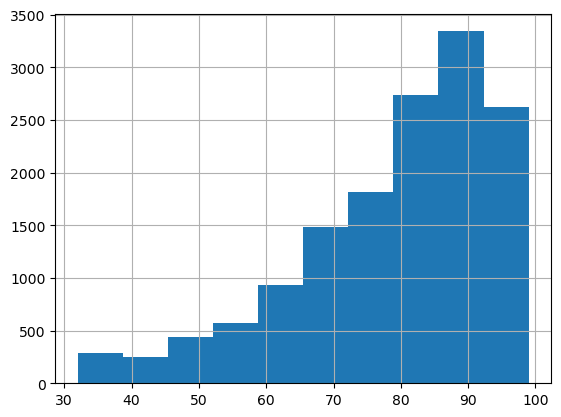

In [12]:
datax["satis_perc"].hist()
# datax["metacritic_score"].hist()

In [13]:
print(datax.loc[(datax['is_free']!=0)].count()) #PAID
print(datax.loc[(datax['is_free']==0)].count()) #F2P

gameid              1726
name                1726
r_age               1726
is_free             1726
i_price             1726
discount            1726
dlc                 1726
dlc_count           1726
metacritic_score    1726
metacritic_url        95
achievements        1726
recom               1726
packages_ids        1726
packages_count      1726
packages            1726
developers          1726
publishers          1698
mtx                 1726
genres              1724
e_owners            1726
avg_p_f             1726
gameage             1726
satis_perc          1726
dtype: int64
gameid              12764
name                12764
r_age               12764
is_free             12764
i_price             12764
discount            12764
dlc                 12764
dlc_count           12764
metacritic_score    12764
metacritic_url       3005
achievements        12764
recom               12764
packages_ids        12764
packages_count      12764
packages            12764
developers          12

In [14]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = datax.select_dtypes(include=numerics)

In [15]:
newdf

,gameid,r_age,is_free,i_price,discount,dlc_count,metacritic_score,achievements,recom,packages_count,mtx,e_owners,avg_p_f,gameage,satis_perc
1,552110,0,1,0.00,0,4,0,49.0,0.0,0,1,50000,1598.0,1877.0,74
7,395860,0,0,9.99,0,0,0,13.0,232.0,1,0,15000,318.0,2823.0,79
17,1532180,0,1,0.00,0,1,0,30.0,0.0,0,0,25000,0.0,897.0,96
30,463030,0,0,0.99,0,0,0,7.0,392.0,1,0,15000,0.0,2683.0,63
35,73010,0,0,19.99,0,14,70,47.0,650.0,1,0,150000,135.0,4568.0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63718,1475430,0,0,8.99,0,0,0,0.0,394.0,1,0,15000,396.0,599.0,60
63721,1083190,0,0,14.99,50,1,0,0.0,167.0,1,0,10000,2.0,1409.0,86
63731,337720,0,0,9.99,0,0,0,19.0,167.0,1,0,15000,0.0,2711.0,97
63734,1152300,0,0,39.99,0,0,0,41.0,328.0,1,0,10000,0.0,1320.0,95


# Correlation Matrix

In [16]:
# Correlation matrix
correlation_matrix = newdf.corr()
print(correlation_matrix)

                    gameid     r_age   is_free   i_price  discount  dlc_count  \
gameid            1.000000 -0.106835 -0.016738  0.134425 -0.016116  -0.027022   
r_age            -0.106835  1.000000 -0.046175  0.183686 -0.003600   0.110746   
is_free          -0.016738 -0.046175  1.000000 -0.376912 -0.070775   0.025317   
i_price           0.134425  0.183686 -0.376912  1.000000  0.045859   0.305795   
discount         -0.016116 -0.003600 -0.070775  0.045859  1.000000   0.019373   
dlc_count        -0.027022  0.110746  0.025317  0.305795  0.019373   1.000000   
metacritic_score -0.310457  0.188455 -0.141117  0.210369  0.036630   0.127277   
achievements     -0.000538  0.045354 -0.065975  0.142299  0.005443   0.233170   
recom            -0.084349  0.238614 -0.082971  0.265819  0.018466   0.261106   
packages_count   -0.140469  0.147317 -0.568083  0.358288  0.061282   0.160753   
mtx               0.007197  0.025073  0.386049 -0.102021 -0.028387   0.098596   
e_owners         -0.172133  

<AxesSubplot: >

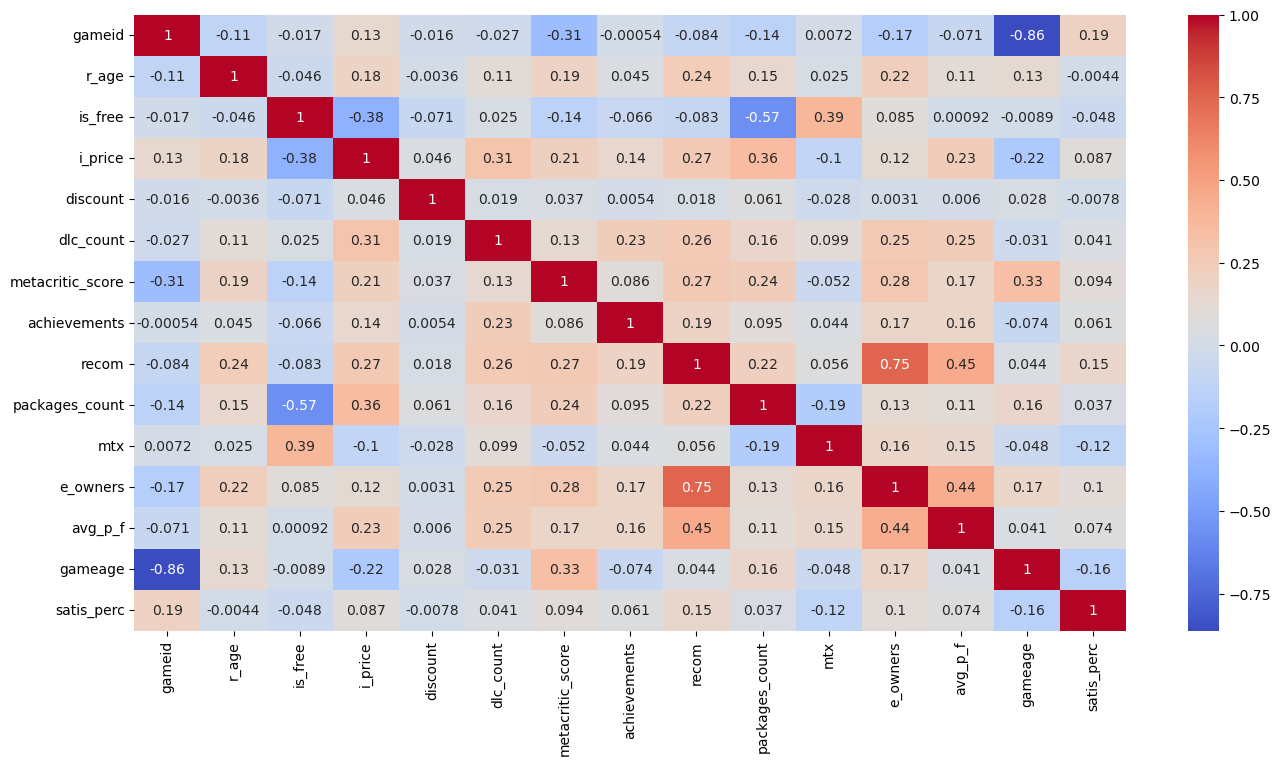

In [17]:
# Heatmap of the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Multicollinearity with VIF

In [18]:
import statsmodels.api as sm

In [19]:
y = newdf['satis_perc']
X = newdf[['i_price', 'dlc_count',
           'packages_count', 'is_free','mtx']]
# X = newdf[['i_price', 'is_free', 'dlc_count', 
#            'packages_count', 'mtx', 'gameage']]

# X = newdf[['i_price', 'dlc_count', 
#            'packages_count']]

In [20]:
# Detecting Multicollinearity with VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

          feature       VIF
0         i_price  2.458208
1       dlc_count  1.301435
2  packages_count  2.276617
3         is_free  1.245529
4             mtx  1.248501


# Regression Models

In [21]:
# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             satis_perc   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     61.89
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           4.64e-64
Time:                        18:52:00   Log-Likelihood:                -59488.
No. Observations:               14490   AIC:                         1.190e+05
Df Residuals:                   14484   BIC:                         1.190e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             78.0702      0.341    229.

In [22]:
# T TEST on difference of satisfaction between F2P and Paid games
from scipy.stats import ttest_ind
# Evaluate difference on IS_FREE or MTX score
onwhat = 'is_free' #is_free  mtx
score = 'satis_perc' #metacritic_score satis_perc

datatt = datax[datax[score]!=0]
group = datatt[[onwhat, score]]

group1 = group[group[onwhat]==1]
group2 = group[group[onwhat]==0]

#perform independent two sample t-test
ttest_ind(group1[score], group2[score])

Ttest_indResult(statistic=-5.799181947388097, pvalue=6.802835086471862e-09)

In [23]:
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
import pandas as pd

In [24]:
#perform White's test
white_test = het_white(results.resid,  results.model.exog)

#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of White's test
print(dict(zip(labels, white_test)))

{'Test Statistic': 251.06569046972422, 'Test Statistic p-value': 1.2641222980603164e-43, 'F-Statistic': 15.010304900193312, 'F-Test p-value': 4.894281579105568e-44}


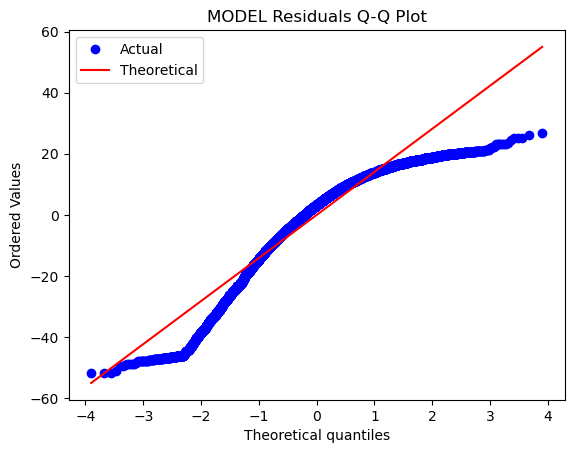

In [25]:
#Import library
from scipy import stats
stats.probplot(results.resid, dist="norm", plot= plt)
plt.title("MODEL Residuals Q-Q Plot")
plt.legend(['Actual','Theoretical'])

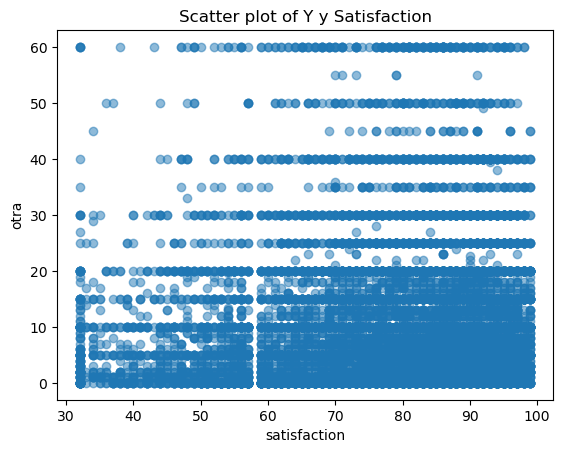

In [26]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
import matplotlib.pyplot as plt
#Marketing spend and Profit
plt.scatter(datax['satis_perc'], datax['i_price'], alpha=0.5)
plt.title('Scatter plot of Y y Satisfaction')
plt.xlabel('satisfaction')
plt.ylabel('otra')
plt.show()

In [27]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy import stats
from statsmodels.compat import lzip
import statsmodels
import matplotlib.pyplot as plt
#For this test, a value of 2, or close to it, is ideal
statsmodels.stats.stattools.durbin_watson(results.resid)

1.9865811127003419

In [28]:
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 114.73999591752462),
 ('p-value', 4.075888642039604e-23),
 ('f-value', 23.12158667596207),
 ('f p-value', 3.32021079067437e-23)]

In [29]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(results.resid)
lzip(name, test)

[('Jarque-Bera', 2900.7178701880835),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', -1.03683682334719),
 ('Kurtosis', 3.7101966314689774)]

<AxesSubplot: title={'center': 'Log of Satisfaction'}, ylabel='Frequency'>

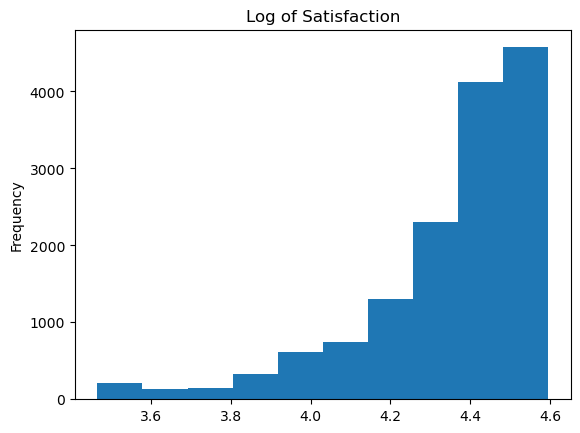

In [30]:
datax['satis_perc'] = np.log(datax['satis_perc'])
datax['satis_perc'].plot(kind='hist', 
                       title= 'Log of Satisfaction')

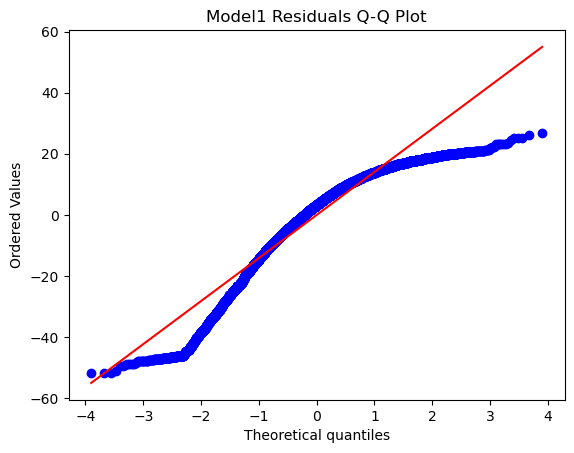

In [31]:
#Running plot & giving it a title
stats.probplot(results.resid, dist="norm", plot= plt)
plt.title("Model1 Residuals Q-Q Plot")

#Saving plot as a png
plt.savefig("Model1_Resid_qqplot.png")

In [32]:
# Regress absolute values of residuals on fitted values
# Save the absolute values of the residuals of the OLS model
y_resid = [abs(resid) for resid in results.resid]

# Add constant according to statsmodels documentation to the fitted values
# of the OLS model
X_resid = sm.add_constant(results.fittedvalues)

# Create OLS model, fit, and print results
mod_resid = sm.OLS(y_resid, X_resid)
res_resid = mod_resid.fit()

# Estimate of std. dev. (sigma)
mod_fv = res_resid.fittedvalues

# Calculate weights
weights = 1 / (mod_fv**2)
weights

1        0.005710
7        0.007382
17       0.007506
30       0.007161
35       0.008271
           ...   
63718    0.007357
63721    0.007551
63731    0.007382
63734    0.008199
63735    0.007382
Length: 14490, dtype: float64

In [33]:
# Fit the weighted least squares model
model = sm.WLS(y, X, weights = weights)
results = model.fit()

# Print the results
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:             satis_perc   R-squared:                       0.017
Model:                            WLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     50.49
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           4.69e-52
Time:                        18:52:07   Log-Likelihood:                -59471.
No. Observations:               14490   AIC:                         1.190e+05
Df Residuals:                   14484   BIC:                         1.190e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             78.2611      0.341    229.